# El precio justo

Hoy construimos una solución más compleja para estimar los precios de los bienes.

1. Cuaderno del día 2.0: crear una base de datos RAG con nuestros 400 000 datos de entrenamiento
2. Cuaderno del día 2.1: visualizar en 2D
3. Cuaderno del día 2.2: visualizar en 3D
4. Cuaderno del día 2.3: crear y probar una canalización RAG con GPT-4o-mini
5. Cuaderno del día 2.4: (a) recuperar nuestro tasador de Bosque aleatorio (b) crear un tasador de conjunto que permita contribuciones de todos los tasadores

¡Uf! ¡Eso es mucho para hacer en un día!

## TEN EN CUENTA:

Ya tenemos un estimador de productos muy poderoso con nuestro LLM patentado y perfeccionado. ¡La mayoría de las personas estarían muy satisfechas con eso! La razón principal por la que agregamos estos pasos adicionales es para profundizar su experiencia con RAG y con los flujos de trabajo de Agentic.

## ¡Hoy iremos rápido! Agárrate el sombrero.

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester

In [2]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
openai = OpenAI()

In [16]:
# Cargar el archivo de prueba en pickle
# Consultar la sección "Volver a los archivos PKL" en el cuaderno day2.0
# para obtener instrucciones sobre cómo obtener este archivo test.pkl

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [12]:
def make_context(similars, prices):
    message = "Para brindar algo de contexto, aquí hay algunos otros elementos que podrían ser similares al elemento que necesita estimar.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Producto potencialmente relacionado:\n{similar}\nEl precio es ${price:.2f}\n\n"
    return message

In [22]:
def messages_for(item, similars, prices):
    system_message = "Estimas los precios de los artículos. Respondes solo con el precio, sin explicaciones."
    user_prompt = make_context(similars, prices)
    user_prompt += "Y la pregunta para ti es:\n\n"
    user_prompt += item.test_prompt().replace("How much does this cost to the nearest dollar?","¿Cuánto cuesta el artículo?").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "El precio es $"}
    ]

In [6]:
DB = "products_vectorstore"

In [7]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [23]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [24]:
description(test[0])

"OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"

In [9]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [10]:
def vector(item):
    return model.encode([description(item)])

In [25]:
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [26]:
test[1].prompt

'How much does this cost to the nearest dollar?\n\nMotorcraft YB3125 Fan Clutch\nMotorcraft YB3125 Fan Clutch Package Dimensions 25.146 cms (L) x 20.066 cms (W) x 15.494 cms (H) Package Quantity 1 Product Type Auto Part Country Of Origin China Manufacturer Motorcraft, Brand Motorcraft, Model Fan Clutch, Weight 5 pounds, Dimensions 10 x 7.63 x 6.25 inches, Country of Origin China, model number Exterior Painted, Manufacturer Part Rank Automotive Automotive Replacement Engine Fan Clutches 583, Domestic Shipping can be shipped within U.S., International Shipping This item can be shipped to select countries outside of the U.S. Learn More, Available October 10, 2007\n\nPrice is $225.00'

In [27]:
documents, prices = find_similars(test[1])

In [28]:
print(make_context(documents, prices))

Para brindar algo de contexto, aquí hay algunos otros elementos que podrían ser similares al elemento que necesita estimar.

Producto potencialmente relacionado:
Motorcraft Fan Clutch Assembly - YB3130
Motorcraft Fan Clutch Assembly - YB3130 Package Dimensions 7.23 L x 4 H x 6.92 W (inches) Package Weight 5 pounds Country of Origin China Part Number YB3130 Manufacturer Motorcraft, Brand Motorcraft, Model Fan Clutch Assembly, Weight 5 pounds, Dimensions 6.87 x 7.32 x 5.62 inches, Country of Origin China, model number Exterior Painted, Manufacturer Part Wattage 6.92 watts, Rank Automotive Automotive Replacement Engine Fan Clutches 698, Available October 10, 2007, Dimensions LxWxH 6.87 x 7.32 x 5.62 inches
El precio es $223.78

Producto potencialmente relacionado:
Motorcraft- YB3126 Fan Clutch
Fan Clutch Package Dimensions 16.764 H x 24.384 L x 20.32 W (centimeters) Part number YB3126 Package Weight 7.4 pounds Fit type Vehicle Specific Brand Motorcraft, Electric fan design Blower, Power S

In [29]:
print(messages_for(test[1], documents, prices))

[{'role': 'system', 'content': 'Estimas los precios de los artículos. Respondes solo con el precio, sin explicaciones.'}, {'role': 'user', 'content': 'Para brindar algo de contexto, aquí hay algunos otros elementos que podrían ser similares al elemento que necesita estimar.\n\nProducto potencialmente relacionado:\nMotorcraft Fan Clutch Assembly - YB3130\nMotorcraft Fan Clutch Assembly - YB3130 Package Dimensions 7.23 L x 4 H x 6.92 W (inches) Package Weight 5 pounds Country of Origin China Part Number YB3130 Manufacturer Motorcraft, Brand Motorcraft, Model Fan Clutch Assembly, Weight 5 pounds, Dimensions 6.87 x 7.32 x 5.62 inches, Country of Origin China, model number Exterior Painted, Manufacturer Part Wattage 6.92 watts, Rank Automotive Automotive Replacement Engine Fan Clutches 698, Available October 10, 2007, Dimensions LxWxH 6.87 x 7.32 x 5.62 inches\nEl precio es $223.78\n\nProducto potencialmente relacionado:\nMotorcraft- YB3126 Fan Clutch\nFan Clutch Package Dimensions 16.764 H

In [30]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [31]:
# The function for gpt-4o-mini

def gpt_4o_mini_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item, documents, prices),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [32]:
gpt_4o_mini_rag(test[1])

209.99

In [33]:
test[1].price

225.11

1: Guess: $346.41 Truth: $374.41 Error: $28.00 SLE: 0.01 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $209.99 Truth: $225.11 Error: $15.12 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $42.50 Truth: $61.68 Error: $19.18 SLE: 0.13 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $399.00 Truth: $599.99 Error: $200.99 SLE: 0.17 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $29.99 Truth: $16.99 Error: $13.00 SLE: 0.30 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $12.99 Truth: $31.99 Error: $19.00 SLE: 0.74 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $68.99 Truth: $101.79 Error: $32.80 SLE: 0.15 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $349.00 Truth: $289.00 Error: $60.00 SLE: 0.04 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $499.99 Truth: $635.86 Error: $135.87 SLE: 0.06 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $61.99 Truth: $65.99 Error: $4.00 SLE: 0.00 It

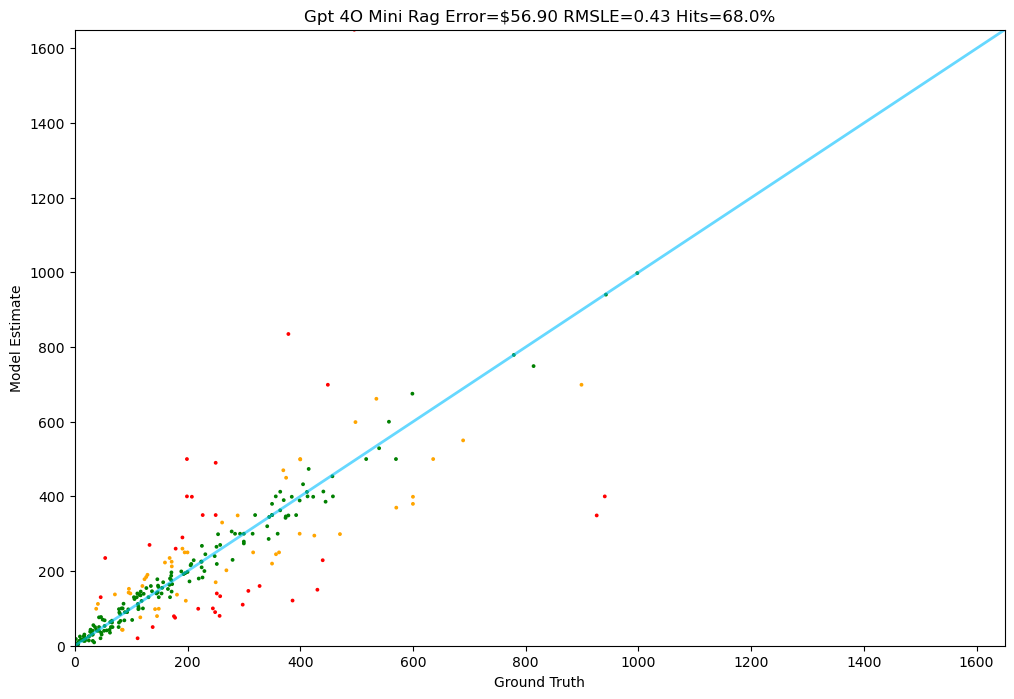

In [34]:
Tester.test(gpt_4o_mini_rag, test)

In [35]:
from agents.frontier_agent import FrontierAgent

In [36]:
agent = FrontierAgent(collection)

In [37]:
agent.price("Micrófono de condensador Quadcast HyperX para podcasting de alta calidad")

139.99

In [38]:
from agents.specialist_agent import SpecialistAgent

In [39]:
agent2 = SpecialistAgent()

In [40]:
agent2.price("Micrófono de condensador Quadcast HyperX para podcasting de alta calidad")

189.0